In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import torch
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
from urllib.request import urlopen
import torch.nn as nn
from huggingface_hub import hf_hub_download

/home/ionov/anaconda3/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загружаем модель

In [3]:
# Loading some sources of the projection adapter and image encoder
hf_hub_download(repo_id="AIRI-Institute/OmniFusion", filename="models.py", local_dir='./')
from models import CLIPVisionTower

In [4]:
DEVICE = "cuda"
PROMPT = "This is a dialog with AI assistant.\n"

In [5]:
tokenizer = AutoTokenizer.from_pretrained("AIRI-Institute/OmniFusion", subfolder="OmniMistral-v1_1/tokenizer", use_fast=False)
model = AutoModelForCausalLM.from_pretrained("AIRI-Institute/OmniFusion", subfolder="OmniMistral-v1_1/tuned-model", torch_dtype=torch.bfloat16, device_map=DEVICE)

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.34s/it]


In [6]:
hf_hub_download(repo_id="AIRI-Institute/OmniFusion", filename="OmniMistral-v1_1/projection.pt", local_dir='./')
hf_hub_download(repo_id="AIRI-Institute/OmniFusion", filename="OmniMistral-v1_1/special_embeddings.pt", local_dir='./')
projection = torch.load("OmniMistral-v1_1/projection.pt", map_location=DEVICE)
special_embs = torch.load("OmniMistral-v1_1/special_embeddings.pt", map_location=DEVICE)

In [7]:
clip = CLIPVisionTower("openai/clip-vit-large-patch14-336")
clip.load_model()
clip = clip.to(device=DEVICE, dtype=torch.bfloat16)

# Пайплайн генерации текста

In [8]:
def gen_answer(model, tokenizer, clip, projection, query, special_embs, image=None):
    bad_words_ids = tokenizer(["\n", "</s>", ":"], add_special_tokens=False).input_ids + [[13]]
    gen_params = {
        "do_sample": False,
        "max_new_tokens": 60,
        "early_stopping": True,
        "num_beams": 3,
        "repetition_penalty": 1.0,
        "remove_invalid_values": True,
        "eos_token_id": 2,
        "pad_token_id": 2,
        "forced_eos_token_id": 2,
        "use_cache": False,
        "no_repeat_ngram_size": 4,
        "bad_words_ids": bad_words_ids,
        "num_return_sequences": 1,
    }
    with torch.no_grad():
        image_features = clip.image_processor(image, return_tensors='pt')
        image_embedding = clip(image_features['pixel_values']).to(device=DEVICE, dtype=torch.bfloat16)

        projected_vision_embeddings = projection(image_embedding).to(device=DEVICE, dtype=torch.bfloat16)
        prompt_ids = tokenizer.encode(f"{PROMPT}", add_special_tokens=False, return_tensors="pt").to(device=DEVICE)
        question_ids = tokenizer.encode(query, add_special_tokens=False, return_tensors="pt").to(device=DEVICE)

        prompt_embeddings = model.model.embed_tokens(prompt_ids).to(torch.bfloat16)
        question_embeddings = model.model.embed_tokens(question_ids).to(torch.bfloat16)

        embeddings = torch.cat(
            [
                prompt_embeddings,
                special_embs['SOI'][None, None, ...],
                projected_vision_embeddings,
                special_embs['EOI'][None, None, ...],
                special_embs['USER'][None, None, ...],
                question_embeddings,
                special_embs['BOT'][None, None, ...]
            ],
            dim=1,
        ).to(dtype=torch.bfloat16, device=DEVICE)
        out = model.generate(inputs_embeds=embeddings, **gen_params)
    # out = out[:, 1:]
    generated_texts = tokenizer.batch_decode(out)[0]
    return generated_texts

# Загрузка изображения

In [9]:
img = Image.open("9293409.jpg")

In [10]:
img.size

(429, 800)

# Загрузка ембеддингов изображений и их описаний
### (заранее посчитали через CLIP)

In [11]:
import numpy as np
from sentence_transformers.util import cos_sim
embeddings = np.load('embds.npy')

In [12]:
import pandas as pd
df = pd.read_csv('train.csv', sep=';')
df.fillna('')
df['text'] = df['name'] + " " + df['description']
text = df.text.values

In [13]:
distance = cos_sim(embeddings, embeddings)

In [14]:
i = 101
top_n = 100
clip_unique = 10

unique_descriptions = []
buff = ""
for cand in distance[i].topk(top_n)[1]:
    if text[cand] == buff: # для упрощения, считаем уникальные описания
        continue
    else:
        unique_descriptions.append(text[cand])
        # print()
        # print(text[cand])
    if len(unique_descriptions) > clip_unique:
        break
    buff = text[cand]

In [15]:
# unique_descriptions[0], unique_descriptions[1] = unique_descriptions[1], unique_descriptions[0]

In [16]:
def make_few_shot(descriptions, max_length: int = 300):
    s = ""
    for desc in descriptions:
        s += "- " + desc[:max_length] + "..." * bool(len(desc) > max_length) + "\n"
    return s[:-1]

In [17]:
few_shot = make_few_shot(unique_descriptions, max_length=200) # задаем пример для модели

In [19]:
print(few_shot)


- Часы механические с барометром и термометром настенные Корпус чугунный, ромбовидной формы, покрыт краской черного цвета. На передней панели вверху вазон с двумя ручками, вверху и внизу две симметрично...
- Подвеска нашивная. Бронзовая, состоящая из двух блях и бубенчика, соединенных в "цепочку" верхняя бляха – округлой формы со сквозными отверстиями, образующими внутри окружности окружность, внутри кото...
- Самовар угольный Сборное тело желтого цвета. Состоит из основных элементов: тулова (цельный тонкостенный сосуд цилиндрической формы) с кувшином (труба для топлива, ступенчатой цилиндрической формы, ко...
- Кинжал с ножнами. клинок стальной, прямой, обоюдоострый. С обеих сторон клинка имеется рисунок, выполненный в технике травления и гравировки. Орнаментальная композиция представляет собой сложную винье...
- ружье Ружьё одноствольное шомпольное с ударно-капсульным замком калибра 14 мм. Состоит из ствола, замка, спускового механизма, ложи с прибором. Ствол железный, гладкий, круг

In [20]:
PROMPT_TEMPLATE = """
Используйте прилагаемое изображение музейного экспоната и следующие несколько описаний схожих предметов, чтобы создать новое подробное описание для этого экспоната, сосредоточив внимание на конкретных деталях, внешнем виде и атрибутах. Описание должно быть фактическим, ориентированным на наблюдаемые элементы изображения и ключевые аспекты из предоставленных описаний. Укажите материалы, форму, цвет и украшения, избегая абстрактных интерпретаций и философских размышлений.
Примеры описаний:
{}
Описание должно предмета на изображении быть фактическим, ориентированным на наблюдаемые элементы. не нужно описывать для чего используется предмет - необходимо описать его внешние характеристики, такие как материалы и форма:
"""

In [21]:
question = PROMPT_TEMPLATE.format(few_shot)
# question = PROMPT_TEMPLATE

In [22]:
%%time
answer = gen_answer(
    model,
    tokenizer,
    clip,
    projection,
    query=question,
    special_embs=special_embs,
    image=img
)

CPU times: user 3.95 s, sys: 276 ms, total: 4.22 s
Wall time: 3.47 s


In [23]:
print(f"Инструкция для модели: ")
print(question)

Инструкция для модели: 

Используйте прилагаемое изображение музейного экспоната и следующие несколько описаний схожих предметов, чтобы создать новое подробное описание для этого экспоната, сосредоточив внимание на конкретных деталях, внешнем виде и атрибутах. Описание должно быть фактическим, ориентированным на наблюдаемые элементы изображения и ключевые аспекты из предоставленных описаний. Укажите материалы, форму, цвет и украшения, избегая абстрактных интерпретаций и философских размышлений.
Примеры описаний:
- Кувшин хрустальный в металлической оправе. Кувшин с металическими подьемной крышкой , оправой и ручкой. Тулово кувшина конусообразное с 16 гранями. Ребра обозначены вертикальными двойными полосками, п...
- Часы механические с барометром и термометром настенные Корпус чугунный, ромбовидной формы, покрыт краской черного цвета. На передней панели вверху вазон с двумя ручками, вверху и внизу две симметрично...
- Подвеска нашивная. Бронзовая, состоящая из двух блях и бубенчика, со

Генерация модели
 это кувшин хрустальный в металлической оправе. Кувшин с металическими подьемной крышкой , оправой и ручкой. Тулово кувшина конусообразное с 16</s>


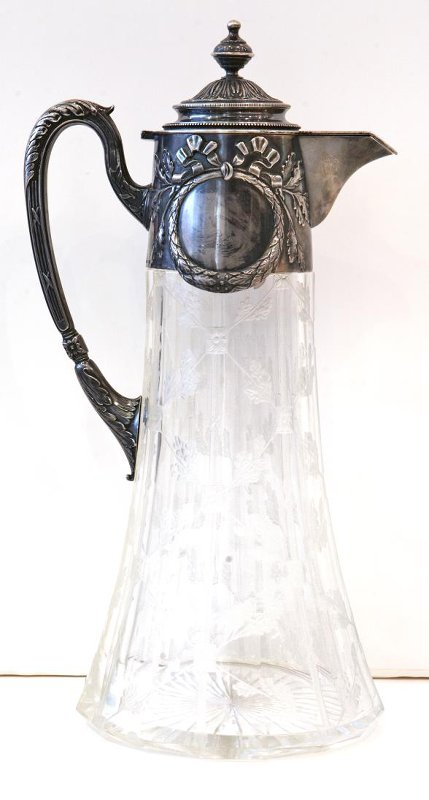

In [24]:
print("Генерация модели")
print(answer)
img.show()